# `FL005_remote_replay` (Frank lab data)

In [1]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


Etienne Ackermann, Sun Dec 03 2017 16:51:58 

CPython 3.6.3
IPython 6.1.0

nelpy 0.1.1
numpy 1.12.1
scipy 0.19.1
pandas 0.21.0


# Overview

Here, I mainly implement Mattias' regression analysis, to determine [quantitatively] which events are considered significant replay, both local and remote.

Mattias used N=10,000 shuffles to compute significance, and I **think** he did this on the linearized positions? Yes, he did indeed. What is still unclear though, is how he decided when to use center-outer ordering and when to use outer-outer ordering? I suppose I will compute both, and use the one with the highest p-value as the event's p-value.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

%matplotlib inline

warnings.filterwarnings("ignore")

In [4]:
fileroot = '../../../../neoReader/' 
infile = 'FrankLabData-BonConFra-no-eeg03b.nel' # saved with Pandas=0.21
outfile = 'FrankLabData-BonConFra-no-eeg05b.nel' # saved with Pandas=0.21
# FrankLabData = nel.load_pkl(fileroot + infile) 
FrankLabData = nel.load_pkl(fileroot + outfile) 

data = FrankLabData.data
sessions = FrankLabData.sessions

# Regression analysis

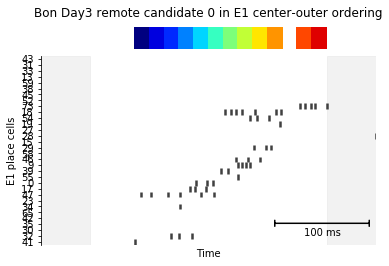

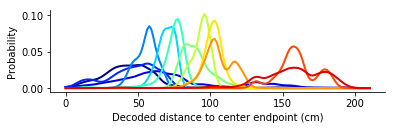

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

E1a, E1b, E2 = 1, 3, 5
animal, day = 'Bon', 'Day3'
evt_idx = 0 # look at paper events, 0, 13, 16, 2

# Also, look at R2-sig, HMM-non-sig @ P < 0.05: 10 18 19 21  ---> all seem to be CORRECTLY discarded by HMM?
# Also, look at R2-sig, HMM-non-sig @ P < 0.03: 10 15 18 19 21 26 34

bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates'][evt_idx]
tc = data[animal][day]['tuning_curves1D_center'][E1b]
evt_extent = bst.support
plot_extent = evt_extent.expand(0.05)
st = data[animal][day]['remote_replay_E1_in_E2']['st_placecells_remote'][plot_extent]
peak_order = tc._unit_subset(st.unit_ids).get_peak_firing_order_ids()

ax = npl.rasterplot(st.reorder_units_by_ids(peak_order), vertstack=True, lw=2.5)
npl.epochplot(plot_extent-evt_extent, hatch='', color='0.9')
ax.set_xlim(*st.support.time)
npl.add_scalebar(ax=ax, sizex=0.1, labelx='100 ms', hidey=False, hidex=False)
npl.utils.clear_right()
npl.utils.clear_top_bottom()
plt.ylabel('E1 place cells')
plt.xlabel('Time')
# ymin, ymax = ax.get_ylim()
posterior, lengths, mode_pth, mean_pth = nel.decoding.decode1D(bst=bst, ratemap=tc.smooth(sigma=4))
# plt.plot(bst.bin_centers, mode_pth*ymax / tc.bin_centers[-1])

divider = make_axes_locatable(ax)
axBins = divider.append_axes("top", size=0.3, pad=0.1)

bins = np.atleast_2d(posterior.sum(axis=0))
non_empty_idx = np.argwhere(~np.isnan(bins))[:,1]
n_non_empty = len(non_empty_idx)
bins[:,non_empty_idx] = np.arange(n_non_empty)

NUM_COLORS = n_non_empty
cm = plt.get_cmap('magma')
cm = plt.get_cmap('jet')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
npl.set_palette(clist)
nan_jet = ListedColormap(clist, name='nan_jet')

axBins.pcolor(bst.bins, [0,1,], bins, cmap=nan_jet)
axBins.set_xlim(ax.get_xlim())
npl.utils.clear_left_right(axBins)
npl.utils.clear_top_bottom(axBins)

axBins.set_title('{} {} remote candidate {} in E1 center-outer ordering'.format(animal, day, evt_idx), y=1.2)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
for post in posterior.T:
    if not any(np.isnan(post)):
        plt.plot(tc.bin_centers, post, lw=2);
plt.xlabel('Decoded distance to center endpoint (cm)')
plt.ylabel('Probability')
npl.utils.clear_right()
npl.utils.clear_top()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
sns.distplot

scores = data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_candidates']
tswap = data[animal][day]['remote_replay_E1_in_E2']['scores_tswap_hmm']

evt_idx = 16
sns.distplot(tswap[:,evt_idx], hist=False)
plt.vlines(scores[evt_idx], 0,1)
plt.title(evt_idx)
npl.savefig('hmm-tswap-{}'.format(evt_idx))

# Regression demo

I am still missing something. Did Mattias sample from P(X|C) AND perform a time swap shuffle? The description is still a little unclear or hard to parse, to me. Since sampling from tight posteriors doesn't do much, for computational efficiency I will do an approximate version now, where I only do time swap regressions on the modes.

In [342]:
import copy

import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import derivative
from types import LambdaType
from math import isnan, log


class _BaseSampling(object):
    # Base class for samplepy sampling package
    
   
    def __check_function__(self, f):
        # Checks if the passed function is a lambda function
        
        return isinstance(f, LambdaType) and f.__name__ == "<lambda>"
        
        
    def __check_defined_over_interval__(self, f, interval):
        # Checks if the passed lambda is defined over the specified interval
        
        if interval[0]< interval[1]:
            try:
                if not isnan(derivative(f, interval[1], dx=1e-6)) and not isnan(derivative(f, interval[0], dx=1e-6)):
                    return True
                else:
                    return False
                
            except:
                raise ValueError("The function is not defined over the entire interval.")
        else:
            raise ValueError("Invalid interval: interval[0] >= interval[1].")
            
class Rejection(_BaseSampling):
    """
       Implements rejection sampling for a specified function over a specififed interval
    """


    def __init__(self, f, interval=[0.0, 1.0]):
        # Constructor accepts the lambda function and the interval over which it should be defined

        if self.__check_function__(f):
            self._f = f
        else:
            raise ValueError("Invalid function provided.")
#         if self.__check_defined_over_interval__(f, interval):
#             self._interval = interval
#         else:
#             raise ValueError("The function is not defined over the entire interval.")
        self._interval = interval
        self._sample = np.array([])
        self.n_dims = len(np.atleast_1d(f((interval[1] - interval[0])/2)))

    def __repr__(self):

        return "multivariate rejection Sampling object, based on samplepy"

    def __len__(self):

        return len(self._sample)

    def __getitem__(self, position):

        return self._sample[position]

    def sample(self, sample_size, seed=None):
        """
         Create a sample set of sample_size samples
         seed (optional, default = 1) to seed the random number generator
        """

        if sample_size < 1:
            raise ValueError("N is not > 1.")

        # seed the random number generator
        if seed:
            np.random.seed(seed)

        # calculate the min&max of f(x) to scale u2
        x = np.arange(self._interval[0], self._interval[1],
                      (abs(self._interval[1]-self._interval[0]))/float(max(sample_size,100)))
        fx = self._f(x)
        max_fx = np.atleast_1d(np.nanmax(fx, axis=-1))
        min_fx = np.atleast_1d(np.nanmin(fx, axis=-1))

        self._sample = np.empty((self.n_dims, sample_size))
        self._sample[:] = np.nan

        for dd in range(self.n_dims):
            i=0
            if any(np.isnan([min_fx[dd], max_fx[dd]])):
                continue
                
            while i < sample_size:
                u1 = np.random.uniform(self._interval[0], self._interval[1])
                fu1 = np.atleast_1d(self._f(u1))[dd]  # _f(u1) is of shape (n_dims, n_samples)         
            
                u2 = np.random.uniform(min_fx[dd], max_fx[dd])

                # collect a full sample here
                if u2 <= fu1:
                    self._sample[dd,i] = u1
                    i += 1

        if self.n_dims == 1:
            self._sample = self._sample.squeeze()
            
        return copy.copy(self._sample)

### Sample from P(X|N)

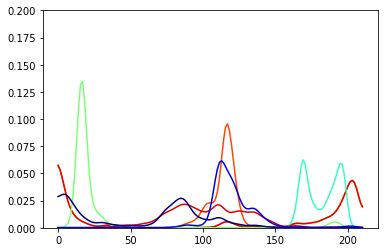

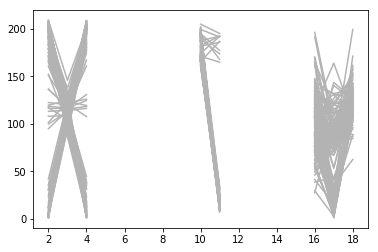

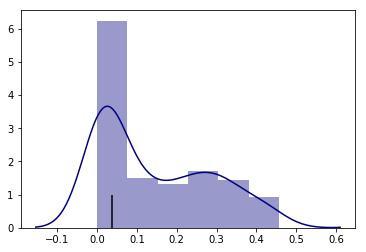

In [379]:
evt_idx = 0
evt = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates'][evt_idx]
posterior, lengths, mode_pth, mean_pth = nel.decoding.decode1D(bst=evt, ratemap=tc.smooth(sigma=4)) # nb! smoothing has a big effect!

pdf = nel.AnalogSignalArray(ydata=posterior.T, timestamps=tc.bin_centers)
ax = npl.plot(pdf)
ax.set_ylim(0,0.2)
plt.show()

f = lambda x: pdf.asarray(at=x).yvals
rej = Rejection(f, [pdf.time[1], pospdf.time[-2]])

sample = rej.sample(sample_size=200)
plt.plot(sample, color='0.7');
plt.show()

import scipy.stats as stats

mask = ~np.isnan(sample.sum(axis=1))
xvals = evt.bin_centers[mask]
yvals = sample[mask]
r2_values = []
for yval in yvals.T:
    slope, intercept, r_value, p_value, std_err = stats.linregress(xvals, yval)
    r2_values.append(r_value**2)
    
slope, intercept, r_value, p_value, std_err = stats.linregress(evt.bin_centers[mask], mode_pth[mask])
actual_r2 = r_value**2
    
sns.distplot(r2_values)
plt.vlines(actual_r2, 0,1)

### Time swap regression analysis on posterior modes

In [56]:
data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_candidates']

array([  0.00000000e+00,   0.00000000e+00,   9.79000000e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.00000000e-04,   2.55050000e-01,   2.21500000e-01,
         2.20000000e-03,   1.37500000e-02,   2.66150000e-01,
         8.54000000e-02,   6.50500000e-01,   4.07500000e-02,
         3.00000000e-04,   0.00000000e+00,   2.03700000e-01,
         1.35000000e-02,   7.70000000e-03,   1.92450000e-01,
         0.00000000e+00,   1.00000000e-03,   0.00000000e+00,
         2.61000000e-01,   1.60550000e-01,   1.00000000e-04,
         4.82150000e-01,   2.00000000e-04,   4.03700000e-01,
         2.00000000e-04,   2.40000000e-03,   8.40000000e-02,
         6.00000000e-04,   4.55500000e-02,   1.00000000e-04])

In [73]:
data[animal][day].keys()

dict_keys(['HMM_E2', 'tuning_curves1D_outer', 'tuning_curves1D_center', 'run_epochs', 'remote_replay_E1_in_E2', 'tuning_curves2D_ideal', 'HMM_E1', 'tuning_curves2D', 'pos_linear_outer_ordering', 'spikes', 'PlaceCellIDs', 'cell_metadata', 'pos_ideal', 'task_metadata', 'pos', 'task_epochs', 'speed', 'pos_linear_center_ordering', 'ripple_epochs', 'VTC_E1', 'VTC_E2'])

pval: 0.0115


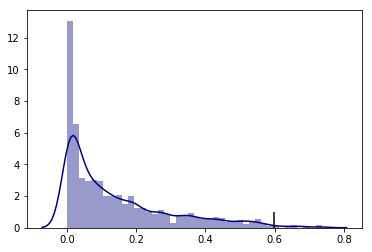

In [95]:
# evts 0 and 1 are good by eye, 2, 7 are not...

# R2 False Positive Bon Day3 remote evt 10 is only false positive by tc outer-E1b
evt_idx = 10
tc = data[animal][day]['tuning_curves1D_outer'][E1b] 
evt = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates'][evt_idx]
posterior, lengths, mode_pth, mean_pth = nel.decoding.decode1D(bst=evt, ratemap=tc.smooth(sigma=4)) # nb! smoothing has a big effect!

mask = ~np.isnan(mode_pth)
xvals = evt.bin_centers[mask]
yvals = mode_pth[mask]

slope, intercept, r_value, p_value, std_err = stats.linregress(xvals, yvals)
actual_r2 = r_value**2

n_shuffles = 10000
r2_values = []
for nn in range(n_shuffles):
    slope, intercept, r_value, p_value, std_err = stats.linregress(xvals, np.random.permutation(yvals))
    r2_values.append(r_value**2)
    
sns.distplot(r2_values)
plt.vlines(actual_r2, 0,1)

pval = (100 - stats.percentileofscore(r2_values, actual_r2))/100
print('pval:', pval)

# Compute time swap p-values for all events

In [88]:
def score_events_r2(bst, tc, n_shuffles=100, sigma=3):
    """Score, and optionally smooth tuning curves when decoding"""
    n_events = bst.n_epochs
    pvals = np.empty(n_events)
    pvals[:] = np.nan
    
    for evt_idx in range(n_events):
        evt = bst[evt_idx]
        _, _, mode_pth, _ = nel.decoding.decode1D(bst=evt, ratemap=tc.smooth(sigma=sigma))

        mask = ~np.isnan(mode_pth)
        xvals = evt.bin_centers[mask]
        yvals = mode_pth[mask]

        slope, intercept, r_value, p_value, std_err = stats.linregress(xvals, yvals)
        actual_r2 = r_value**2

        r2_values = []
        for nn in range(n_shuffles):
            slope, intercept, r_value, p_value, std_err = stats.linregress(xvals, np.random.permutation(yvals))
            r2_values.append(r_value**2)

        pvals[evt_idx] = (100 - stats.percentileofscore(r2_values, actual_r2))/100
        
    return pvals

**TODO:** I just pick the smallest p-value, but I should probably return where it came from (i.e., which ordering, and whether it is E1a or E1b) 

In [89]:
n_shuffles = 10000
sigma_tc = 3 # cm smoothing

for animal, day in [sessions[1]]:
    print(animal, day)
    try:
        bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']
    except KeyError:
        print('The (animal, day) pair does not have remote replay analysis results; skipping...')
        continue
    
    ############ remote candidates ############
    print('scoring remote replay candidates...')
    bst = data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates']

    # compute pvals of remote candidates using center-ordering from E1a
    tc = data[animal][day]['tuning_curves1D_center'][E1a]
    pvals_E1a_co = score_events_r2(bst=bst, tc=tc, n_shuffles=n_shuffles, sigma=sigma_tc)
    # compute pvals of remote candidates using center-ordering from E1b
    tc = data[animal][day]['tuning_curves1D_center'][E1b]
    pvals_E1b_co = score_events_r2(bst=bst, tc=tc, n_shuffles=n_shuffles, sigma=sigma_tc)
    # compute pvals of remote candidates using outer-ordering from E1a
    tc = data[animal][day]['tuning_curves1D_outer'][E1a]
    pvals_E1a_oo = score_events_r2(bst=bst, tc=tc, n_shuffles=n_shuffles, sigma=sigma_tc)
    # compute pvals of remote candidates using outerr-ordering from E1b
    tc = data[animal][day]['tuning_curves1D_outer'][E1b]
    pvals_E1b_oo = score_events_r2(bst=bst, tc=tc, n_shuffles=n_shuffles, sigma=sigma_tc)
    
    pvals = np.vstack((pvals_E1a_co, pvals_E1b_co, pvals_E1a_oo, pvals_E1b_oo)).min(axis=0)
    data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_candidates'] = pvals
           
    ############ local candidates ############
    print('scoring local replay candidates...')
    bst = data[animal][day]['remote_replay_E1_in_E2']['bst_local_candidates']

    # compute pvals of local candidates using center-ordering from E2
    tc = data[animal][day]['tuning_curves1D_center'][E2]
    pvals_E2_co = score_events_r2(bst=bst, tc=tc, n_shuffles=n_shuffles, sigma=sigma_tc)
    # compute pvals of remote candidates using outer-ordering from E2
    tc = data[animal][day]['tuning_curves1D_outer'][E2]
    pvals_E2_oo = score_events_r2(bst=bst, tc=tc, n_shuffles=n_shuffles, sigma=sigma_tc)
    
    pvals = np.vstack((pvals_E2_co, pvals_E2_oo)).min(axis=0)
    data[animal][day]['remote_replay_E1_in_E2']['pvals_local_candidates'] = pvals

Bon Day3
scoring remote replay candidates...
scoring local replay candidates...


In [91]:
animal, day = 'Bon', 'Day3'

np.argwhere(data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_candidates'] < 0.05).squeeze()

array([ 0,  1,  3,  4,  5,  6,  9, 10, 14, 15, 16, 18, 19, 21, 22, 23, 26,
       28, 30, 31, 33, 34, 35], dtype=int64)

Now that we've scored remote replay [of E1] in E2, we can do a few checks to see if we're still in line...

> Despite the distinct representations of environment 1 and environment 2, 182 of 442 (41.2%) candidate replay events showed statistically significant replay (P < 0.05) of environment 1 when rats were located in environment 2 (Z=12.67, P<1e-10, **Fig. 4a-1** and **supplementary Figs. 6** and **7** online).

> As expected, there were also many replays of environment 2; 147 of 330 (44.6%) candidate events were significant (Z=14.45, P<10e-10).


In [22]:
n_sig_local = 0
n_tot_local = 0

n_sig_remote = 0
n_tot_remote = 0

for animal, day in sessions:
    try:
        # local
        x = data[animal][day]['remote_replay_E1_in_E2']['pvals_local_candidates']
        n_sig_local += np.count_nonzero(x<0.05)
        n_tot_local += len(x)
        # remote
        x = data[animal][day]['remote_replay_E1_in_E2']['pvals_remote_candidates']
        n_sig_remote += np.count_nonzero(x<0.05)
        n_tot_remote += len(x)
    except KeyError:
        continue

print('{} of {} ({:1.1f}%) candidate replay events showed statistically significant replay (P < 0.05) of environment 1 when rats were located in environment 2.'.format(n_sig_remote, n_tot_remote, n_sig_remote/n_tot_remote*100))
print('\nAs expected, there were also many replays of environment 2; {} of {} ({:1.1f}%) candidate events were significant.'.format(n_sig_local, n_tot_local, n_sig_local/n_tot_local*100))


270 of 623 (43.3%) candidate replay events showed statistically significant replay (P < 0.05) of environment 1 when rats were located in environment 2.

As expected, there were also many replays of environment 2; 101 of 424 (23.8%) candidate events were significant.


### Save augmented data

In [24]:
FrankLabData = nel.ResultsContainer(data=data,
                                    sessions=FrankLabData.sessions,
                                    cellinfo=FrankLabData.cellinfo,
                                    taskinfo=FrankLabData.taskinfo,
                                    tetinfo=FrankLabData.tetinfo,
                                    description=FrankLabData.description)

FrankLabData.save_pkl(fileroot + outfile)